In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import json
from sklearn.preprocessing import LabelEncoder

In [2]:
# data_file = "iris.json"
# # Load and prepare data
# data = load_iris()
# X = data.data
# y = data.target
# feature_names = list(data.feature_names)
# target_names = list(data.target_names)

# # PCA setup 
# step = 0.05

In [3]:
df = pd.read_csv ("test_dataset.csv")
df.dropna(inplace=True)
data_file = 'fishing.json'

target_names = [
    "Poor Session", "Below Average", "Average Session", "Above Average", 
    "Good Session", "Great Session", "Excellent Session", 
    "Outstanding", "Legendary", "Epic"
]
feature_names = ['engine_age', 'length', 'power', 'month', 'weight', 'y_month',
       'year', 'surf_temp']

#remove non numerical data 
# value adjusted for inflation (check dataset page for more info)
# other non relevant/not known features 
df.drop(["landing", "patch", "value_cpi", "y_", "ID", "dist", "patch_area", "weight_lym", "weight_lm", "val_lm", "val_lym", "nao_index", "price"], axis=1, inplace=True)

y = df["value"]
X = df[feature_names]

# Split the values into 10 categories with meaningful labels
y = pd.cut(y, bins=10, labels=target_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert categories to numerical values

# PCA setup 
step = 0.2 

In [4]:
# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [5]:
# Split the data and train the tree (following your original script)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
dt_classifier_pca = DecisionTreeClassifier(random_state=42)  # Removed max_depth constraint
dt_classifier_pca.fit(X_train_pca, y_train)

# Generate decision boundary data with finer grid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [6]:
# Get predictions for the grid
Z = dt_classifier_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Get prediction probabilities for more detailed visualization
Z_prob = dt_classifier_pca.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_prob = Z_prob.reshape((xx.shape[0], xx.shape[1], -1))

In [7]:
# # Create grid points and predictions for the frontend
# grid_points = []
# for i in range(len(xx)):
#     for j in range(len(xx[0])):
#         grid_points.append({
#             'x': float(xx[i][j]),
#             'y': float(yy[i][j]),
#             'class': int(Z[i][j]),
#         })

C:\Users\alex1\AppData\Local\Temp\ipykernel_9464\1365517753.py:8: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in CS.collections:


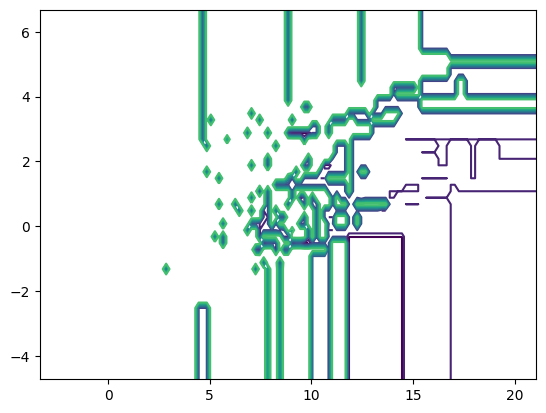

In [8]:
import matplotlib.pyplot as plt

# Suppose you have multiple classes; you can generate contours for each class boundary.
# For example, to get the boundary between two classes, you might set a specific level.
# Adjust the levels based on your specific case.
CS = plt.contour(xx, yy, Z, levels=np.arange(len(target_names) + 1))
boundary_paths = []
for collection in CS.collections:
    for path in collection.get_paths():
        vertices = path.vertices.tolist()  # list of [x, y] coordinates
        boundary_paths.append(vertices)

In [9]:
# ramer douglas peucker on boundary paths
import numpy as np

def perpendicular_distance(point, start, end):
    """
    Calculate the perpendicular distance of 'point' from the line formed by 'start' and 'end'.
    """
    point = np.array(point)
    start = np.array(start)
    end = np.array(end)
    
    # If start and end are the same, return the Euclidean distance from point to start
    if np.array_equal(start, end):
        return np.linalg.norm(point - start)
    
    # Compute the area of the triangle and then the distance.
    # The formula: distance = |(end - start) x (start - point)| / ||end - start||
    return np.abs(np.cross(end - start, start - point)) / np.linalg.norm(end - start)

def rdp(points, epsilon):
    """
    Recursively simplify the list of points using the RDP algorithm.
    """
    if len(points) < 3:
        return points

    # Find the point with the maximum distance from the line connecting the first and last point.
    start, end = points[0], points[-1]
    max_distance = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = perpendicular_distance(points[i], start, end)
        if d > max_distance:
            max_distance = d
            index = i

    # If the maximum distance is greater than epsilon, recursively simplify.
    if max_distance > epsilon:
        left_rec = rdp(points[:index+1], epsilon)
        right_rec = rdp(points[index:], epsilon)
        # Combine the results, omitting the duplicate point at the junction.
        return left_rec[:-1] + right_rec
    else:
        return [start, end]

epsilon = 0.3

simplified_boundary_paths = []
for path in boundary_paths:
    simplified_path = rdp(path, epsilon)
    simplified_boundary_paths.append(simplified_path)

# Now `simplified_boundary_paths` contains your simplified contours,
# which you can pass to your d3.js visualization.
for i in range(len(boundary_paths)):
    print("Original number of points in first boundary:", len(boundary_paths[i]))
    print("Simplified number of points in first boundary:", len(simplified_boundary_paths[i]))


Original number of points in first boundary: 107
Simplified number of points in first boundary: 12
Original number of points in first boundary: 428
Simplified number of points in first boundary: 46
Original number of points in first boundary: 879
Simplified number of points in first boundary: 93
Original number of points in first boundary: 883
Simplified number of points in first boundary: 103
Original number of points in first boundary: 917
Simplified number of points in first boundary: 116
Original number of points in first boundary: 945
Simplified number of points in first boundary: 126
Original number of points in first boundary: 948
Simplified number of points in first boundary: 121
Original number of points in first boundary: 948
Simplified number of points in first boundary: 146


In [10]:
with open (data_file, "w") as f:
    json.dump (
        {
            "pcaData": X_pca.tolist(),
            "targets": y.tolist(),
            "targetNames": list(target_names),
            "decisionBoundary": {
                # "points": grid_points,
                # "boundaryPaths": boundary_paths,
                "boundaryPaths": simplified_boundary_paths,
                "xRange": [float(x_min), float(x_max)],
                "yRange": [float(y_min), float(y_max)],
                "step": step
            },
        },
        f,
        indent=4
    )